# 1D harmonic oscillator physics-informed neural network (PINN)

https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb

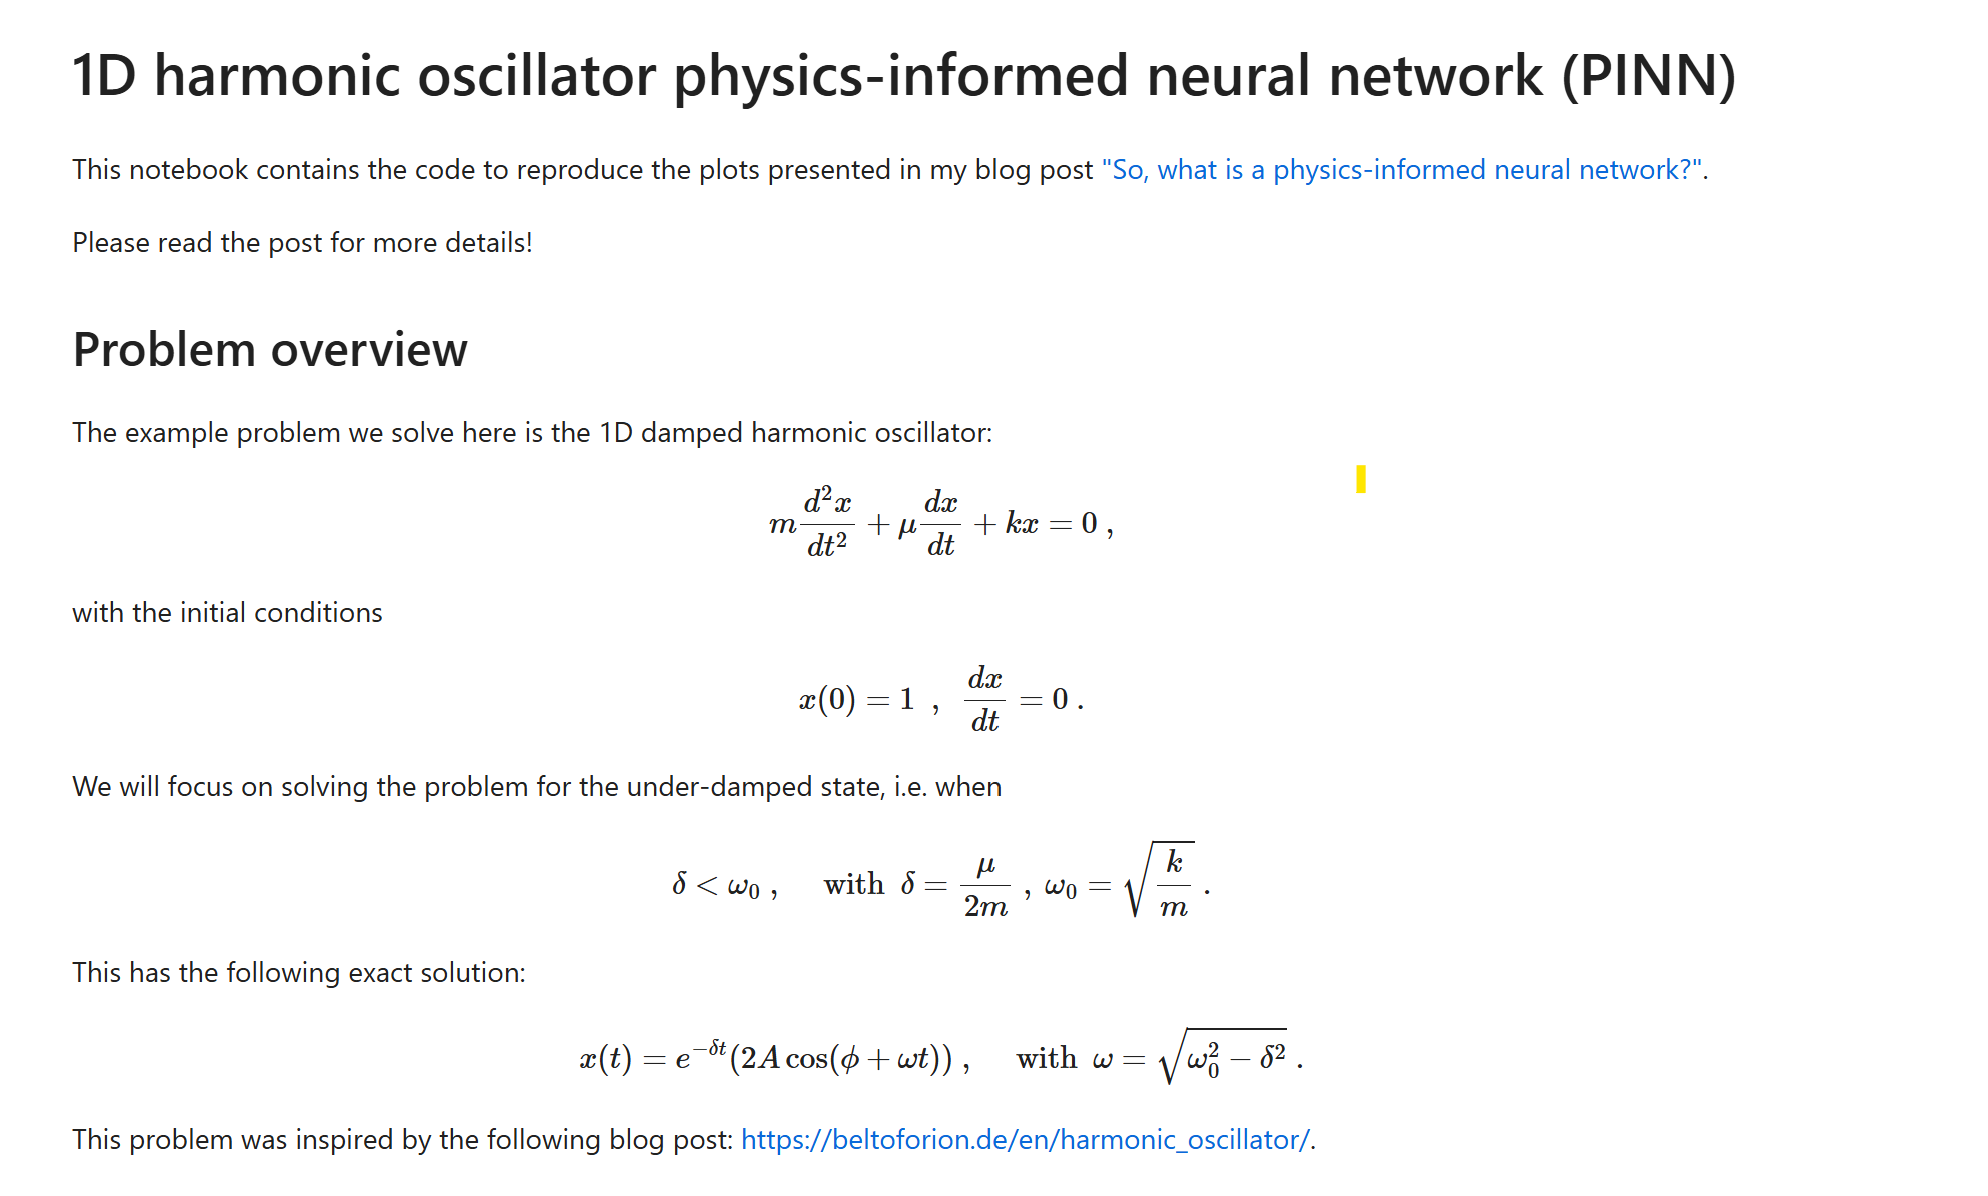

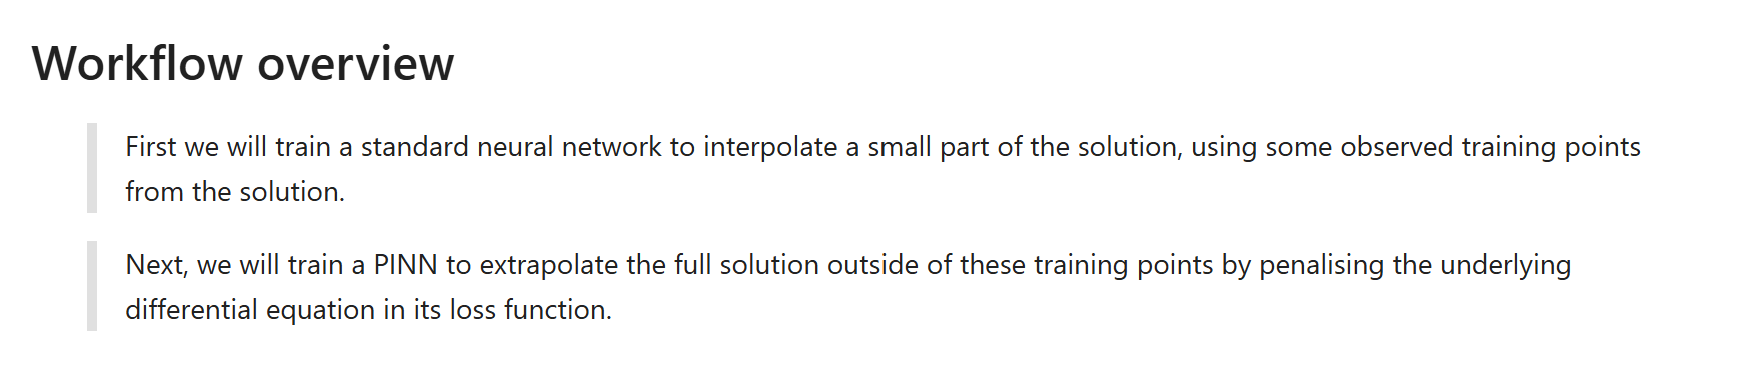

In [21]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [22]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

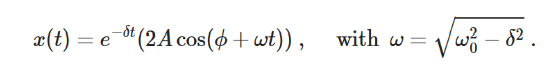

In [23]:
# this is the exact solution to the 1D underdamped harmonic oscillator problem
# taken from: https://beltoforion.de/en/harmonic_oscillator/
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


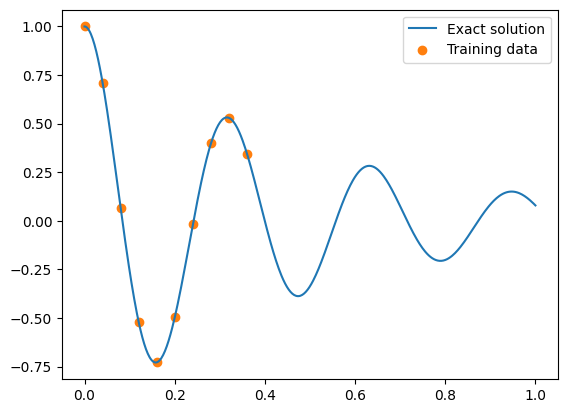

In [24]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [25]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [26]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [27]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

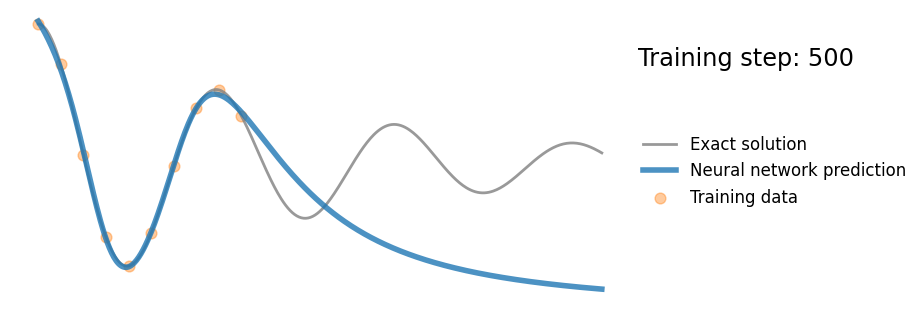

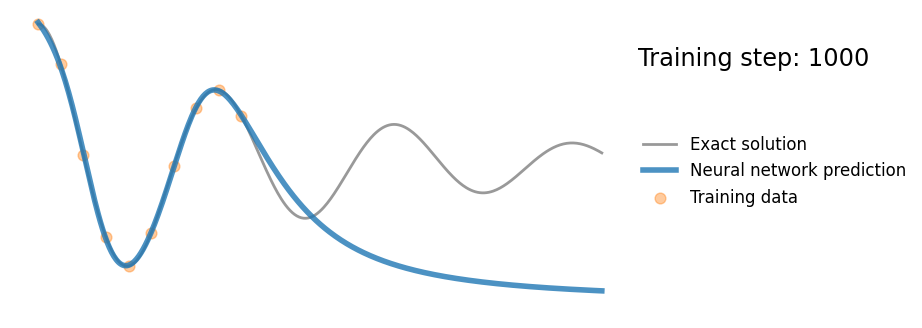

In [28]:
import os


files = []

if not os.path.exists("plots"):
    os.makedirs("plots")

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("nn.gif", files, fps=20, loop=0)

## PINN
Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain 
. We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

In [29]:


#  initialized at the beginning 
# d = 2, 
# w0 = 20

mu, k = 2*d, w0**2


torch.manual_seed(123)

# same standard neural network
# 3 layers and 32 hidden units
model = FCN(1,1,32,3)

# same optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

# let's save the files to create the gif later: 
files = []

Loss function:

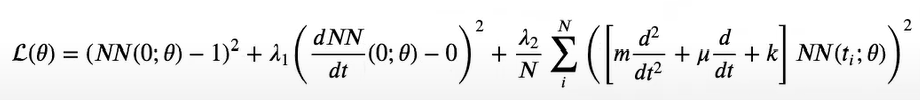

boundary: 

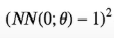

only 1 point, as it's a 1 dimension problem.

`requires_grad = True` 

pytorch, by default, doesn't track the computation graph, for efficiency.
but we want, so we need explicitely to say, which gradients, with respect to this sensor which we do.


so we're going to do that and then we're going to just make sure that it's a nice shape for the input of the network so it so remember the network in pi to watch has a batch Dimension here

In [30]:
# define boundary points for boundary loss
#  only one point: when t=0

t_boundary = torch.tensor(0., requires_grad=True)

#  proper shape for the input of the network
t_boundary = t_boundary.view(-1,1)



now, colocation points for the physics loss.

here we will have points for the whole domain:

In [31]:
# linspace(0,1,30) ->  This function generates a sequence of 30 evenly spaced values between 0 and 1.

# .view(-1, 1) ->  reshapes the tensor into a 2-dimensional tensor with 30 rows and 1 column.
# The -1 argument means that the number of rows is inferred from the length of the tensor, and 1 specifies the number of columns.

# .requires_grad_(True) -> gradients should be computed for this tensor during the backward pass.
#  used  in optimization problems and neural network training where you need to compute gradients for updating parameters.

x_physics = torch.linspace(0,1,30, requires_grad=True).view(-1,1) # sample locations over the problem domain

In [32]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

**boundary loss 1**
   
u = model(t_boundary)

loss1 = torch.squeeze((u-1)**2)  # use mean squared error




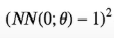


**boundary loss 2**

`autograd` is not actually computing the jacobian.
it's computing the vector Jacobian product, when we are using reverse mode.
So we need also to define what the vector is, what we are applying to that jacobian vector product, 

`torch.ones_like(yhp)` 

` dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx`

`loss2 = torch.sqeeze((dx-0) ** 2)` 



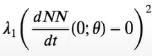


physics loss (loss 3)

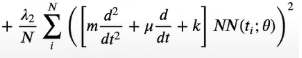

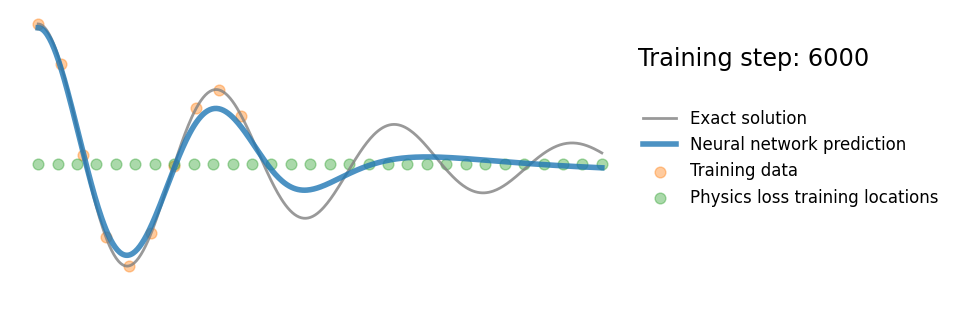

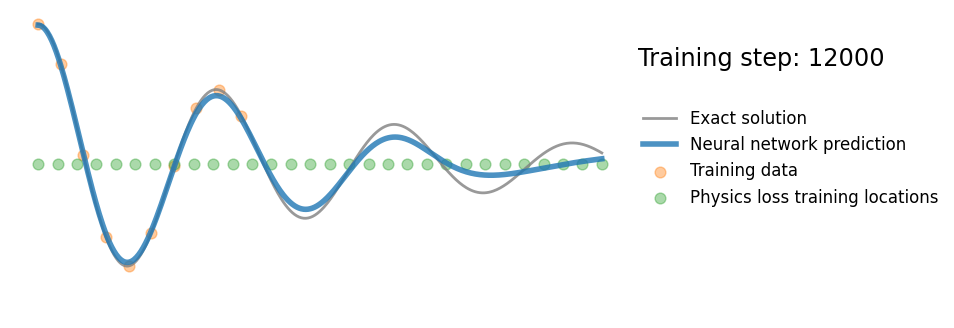

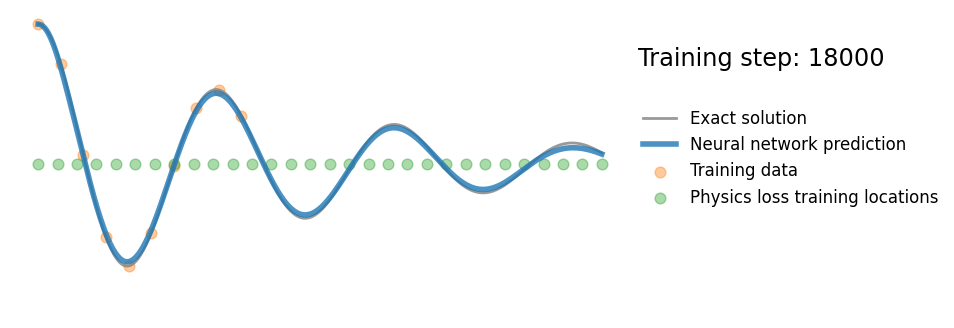

In [33]:



for i in range(20000):
    optimizer.zero_grad()
    
    lambda1, lambda2 = 1e-1, 1e-4

    # compute the boundary loss
    u = model(t_boundary)
    loss1 = torch.squeeze((u-1)**2)  # use mean squared error


    # yh = model(x_data)
    # loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    du = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]# computes dy/dx
    loss2 = torch.squeeze(du**2) # add the boundary loss term


    # compute the "physics loss"
    u = model(x_physics)
    du  = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]# computes dy/dx
    du2 = torch.autograd.grad(du,  x_physics, torch.ones_like(u),  create_graph=True)[0]# computes d^2y/dx^2
    loss3 = torch.mean((du2 + mu*du + k*u)** 2) # computes the residual of the 1D harmonic oscillator differential equation (loss 3 = pyhsics loss)


    # # compute the "physics loss"
    # yhp = model(x_physics)
    # dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    # dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    # physics = dx2 + mu*dx + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
    # loss2 = lambda2 * torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3  # add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)
